# M4 Datasets Exploration

M4 dataset can be downloaded from [Kaggle](https://www.kaggle.com/yogesh94/m4-forecasting-competition-dataset)

More details on the dataset [here](https://www.sciencedirect.com/science/article/pii/S0169207019301128)

In [77]:
import os
import json
from enum import Enum

from numpy.random import randn
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4)
pd.options.display.max_rows = 20
import seaborn as sns
from IPython.display import display

import statsmodels.tsa.seasonal as seasonal

In [25]:
# Input
INPUT_DIR = "../input"

Datasets = Enum('Datasets', 'Hourly Daily Monthly Quarterly')

def load_dataset(dataset):
    train_filepath = os.path.join(INPUT_DIR, dataset.name + "-train.csv")
    test_filepath = os.path.join(INPUT_DIR, dataset.name + "-test.csv")
    
    return pd.read_csv(train_filepath, sep=',', header=0, index_col=0, engine='python'), pd.read_csv(test_filepath, sep=',', header=0, index_col=0, engine='python')

In [26]:
hourly_train, hourly_test = load_dataset(Datasets.Hourly)
daily_train, daily_test = load_dataset(Datasets.Daily)
monthly_train, monthly_test = load_dataset(Datasets.Monthly)
quarterly_train, quarterly_test = load_dataset(Datasets.Quarterly)

In [27]:
hourly_train.shape, hourly_test.shape

((414, 960), (414, 48))

In [28]:
daily_train.shape, daily_test.shape

In [29]:
monthly_train.shape, monthly_test.shape

In [30]:
quarterly_train.shape, quarterly_test.shape

In [31]:
hourly_train.head()

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V952,V953,V954,V955,V956,V957,V958,V959,V960,V961
V1,,,,,,,,,,,,,,,,,,,,,
H1,605.0,586.0,586.0,559.0,511.0,443.0,422.0,395.0,382.0,370.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H2,3124.0,2990.0,2862.0,2809.0,2544.0,2201.0,1996.0,1861.0,1735.0,1713.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H3,1828.0,1806.0,1897.0,1750.0,1679.0,1620.0,1463.0,1342.0,1192.0,1108.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H4,6454.0,6324.0,6075.0,5949.0,5858.0,5579.0,5163.0,4790.0,4478.0,4227.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H5,4263.0,4297.0,4236.0,4080.0,3883.0,3672.0,3248.0,2841.0,2513.0,2275.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


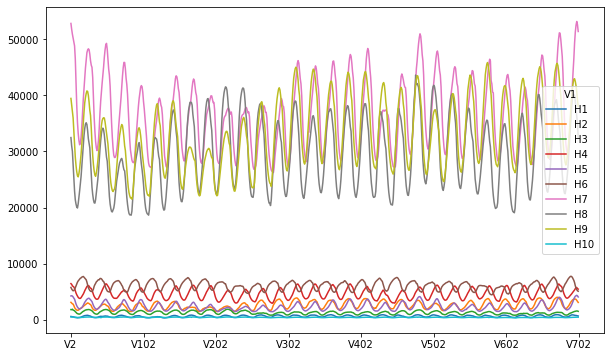

In [32]:
# Lots of seasonality in there
hourly_train.iloc[0:10, ].transpose().plot()

In [33]:
hourly_train.min().min()

10.0

In [34]:
hourly_train.max().max()

703008.0

In [35]:
# Because every time series is not the same length NaN is used as passing at the end
hourly_train.transpose().isnull().sum()

V1
H1      260
H2      260
H3      260
H4      260
H5      260
       ... 
H410      0
H411      0
H412      0
H413      0
H414      0
Length: 414, dtype: int64

In [36]:
# Test data is clean, with no end padding

In [37]:
hourly_test.isnull().sum().sum()

0

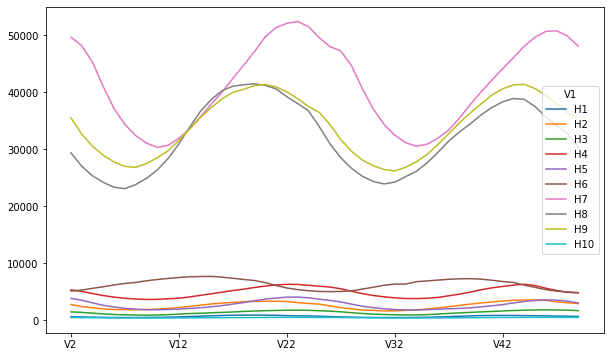

In [38]:
hourly_test.iloc[0:10, ].transpose().plot()

In [39]:
hourly_train.iloc[0, ].first_valid_index()

'V2'

In [40]:
 hourly_train.iloc[0, ].last_valid_index()

'V701'

In [56]:
def trim(df, index):
    """Return the time series at index, with the end NaN padding removed (not all M4 TS are the same length)."""
    s = df.iloc[index, ]
    return s.loc[:s.last_valid_index()]

ht0 = trim(hourly_train, 0)

In [57]:
# For performance, confirm that this is returning a view, not a copy
hourly_train.values.base is ht0.values.base

True

In [58]:
# Now check all data for NaN once trimed
dfs = []
dfs.append(hourly_train)
dfs.append(hourly_test)

for df in dfs:
    for i in range(df.shape[0]):
        assert(trim(df, i).isnull().sum() == 0)

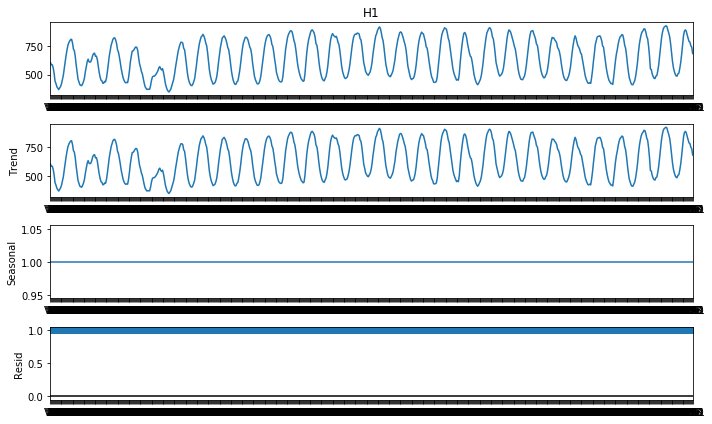

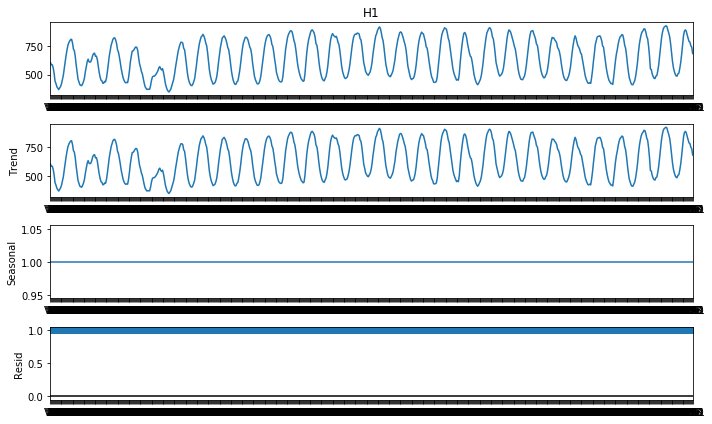

In [75]:
# Let's try naive decomposition... 
# actually neither Multiplicative or Additive models are able to extract the obvious seasonality of H0 without period defined.
result = seasonal.seasonal_decompose(ht0, period=1, model='multiplicative')
result.plot()

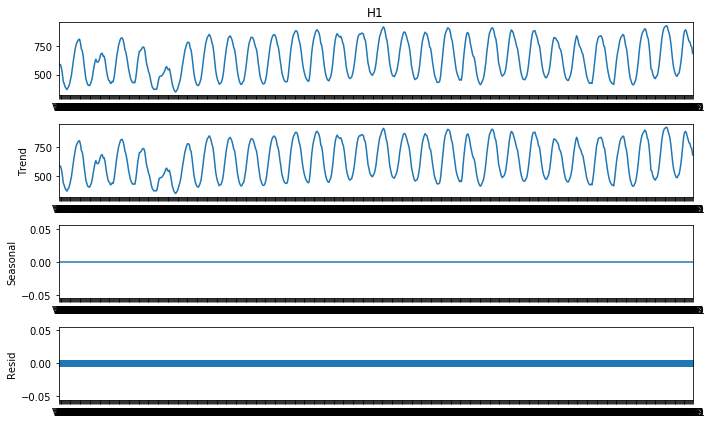

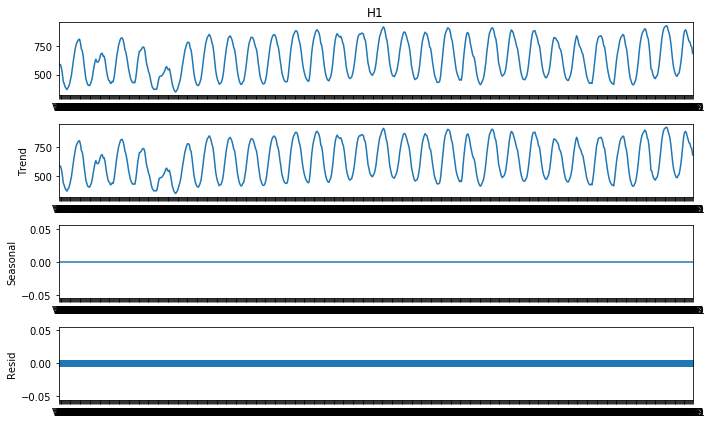

In [73]:
result = seasonal.seasonal_decompose(ht0, period=1, model='additive')
result.plot()

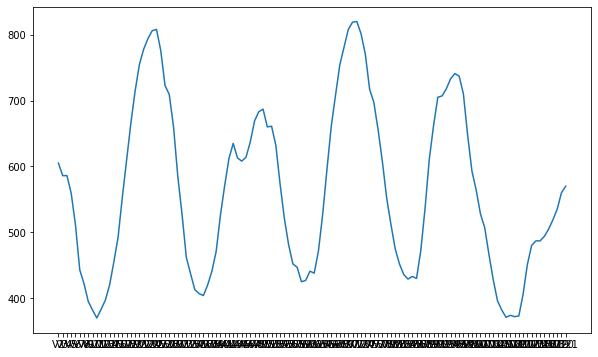

In [92]:
# Let's try to define a proper period
plt.plot(ht0[0:120])

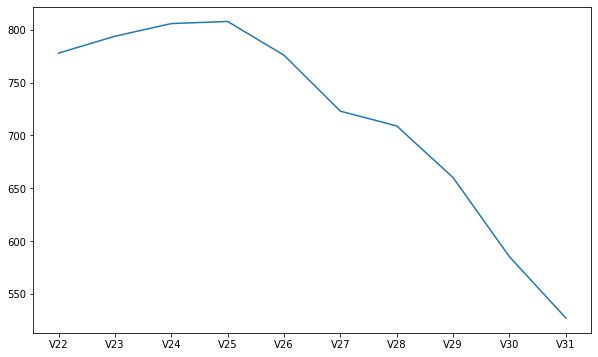

In [93]:
plt.plot(ht0[20:30])

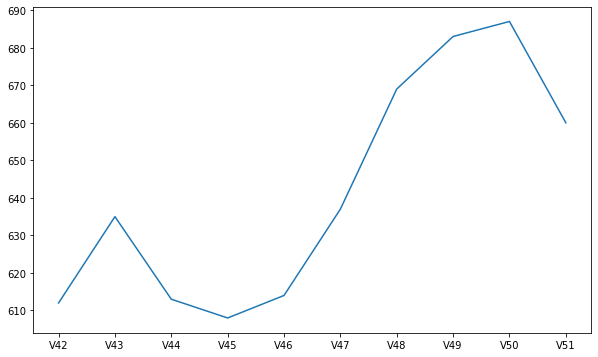

In [94]:
plt.plot(ht0[40:50])

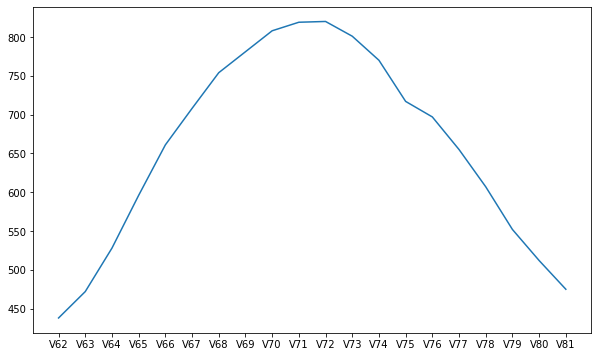

In [96]:
plt.plot(ht0[60:80])

In [111]:
# We're probably talking about daily patterns
(72 - 24) // 2

24

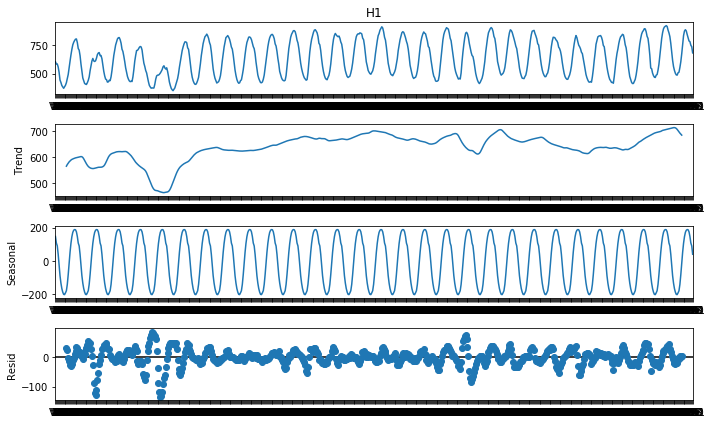

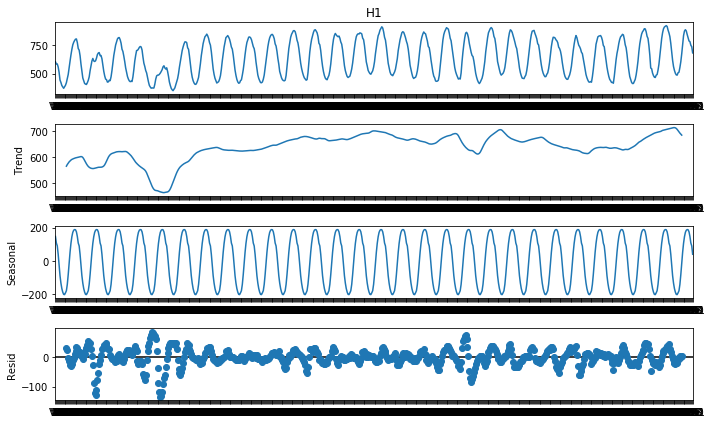

In [109]:
# Already better (some seasonality extracted)
result = seasonal.seasonal_decompose(ht0, period=24, model='additive')
result.plot()

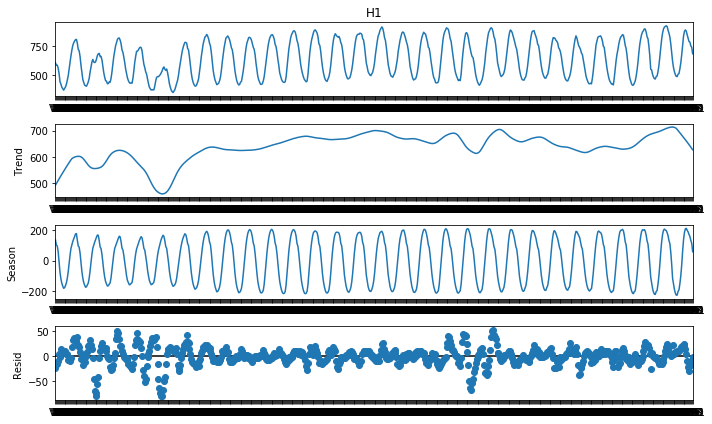

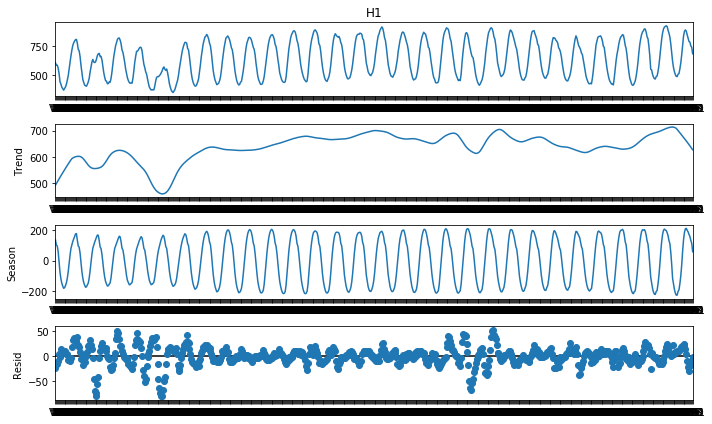

In [110]:
# A more sophisticated decomposition: Season-Trend decomposition using LOESS.
# Much better. The trend still looks off. 
result = seasonal.STL(ht0, period=24).fit()
result.plot()